# This notebook details the EEG simulation using MNE 

    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading forward solution from /Users/ssackstein/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    MEG and EEG forward solutions combined
    Source spaces transformed to the forward solution coordinate frame
Reading labels 

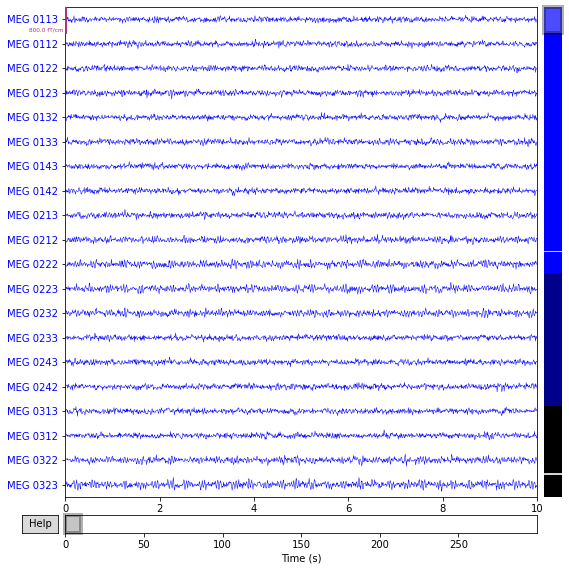

50 events found
Event IDs: [1]
Not setting metadata
50 matching events found
Setting baseline interval to [-0.049948803289596964, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated


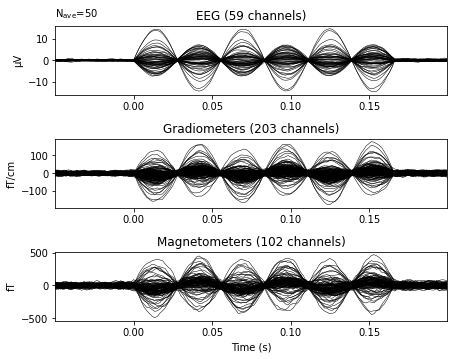

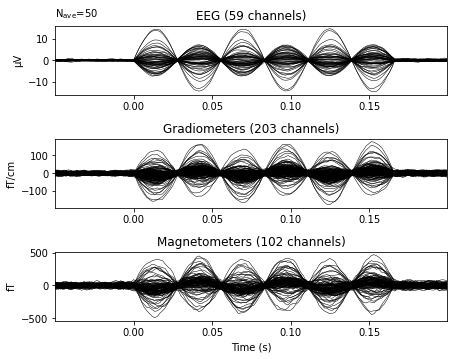

In [1]:
import os.path as op

import numpy as np

import mne
from mne.datasets import sample


# For this example, we will be using the information of the sample subject.
# This will download the data if it not already on your machine. We also set
# the subjects directory so we don't need to give it to functions.
data_path = sample.data_path()
subjects_dir = op.join(data_path, 'subjects')
subject = 'sample'

# First, we get an info structure from the test subject.
evoked_fname = op.join(data_path, 'MEG', subject, 'sample_audvis-ave.fif')
info = mne.io.read_info(evoked_fname)
tstep = 1. / info['sfreq']

# To simulate sources, we also need a source space. It can be obtained from the
# forward solution of the sample subject.
fwd_fname = op.join(data_path, 'MEG', subject,
                    'sample_audvis-meg-eeg-oct-6-fwd.fif')
fwd = mne.read_forward_solution(fwd_fname)
src = fwd['src']

# To select a region to activate, we use the caudal middle frontal to grow
# a region of interest.
selected_label = mne.read_labels_from_annot(
    subject, regexp='caudalmiddlefrontal-lh', subjects_dir=subjects_dir)[0]
location = 'center'  # Use the center of the region as a seed.
extent = 10.  # Extent in mm of the region.
label = mne.label.select_sources(
    subject, selected_label, location=location, extent=extent,
    subjects_dir=subjects_dir)

# Define the time course of the activity for each source of the region to
# activate. Here we use a sine wave at 18 Hz with a peak amplitude
# of 10 nAm.
source_time_series = np.sin(2. * np.pi * 18. * np.arange(100) * tstep) * 10e-9

# Define when the activity occurs using events. The first column is the sample
# of the event, the second is not used, and the third is the event id. Here the
# events occur every 200 samples.
n_events = 50
events = np.zeros((n_events, 3), int)
events[:, 0] = 100 + 200 * np.arange(n_events)  # Events sample.
events[:, 2] = 1  # All events have the sample id.

# Create simulated source activity. Here we use a SourceSimulator whose
# add_data method is key. It specified where (label), what
# (source_time_series), and when (events) an event type will occur.
source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep,duration=300)
source_simulator.add_data(label, source_time_series, events)

# Project the source time series to sensor space and add some noise. The source
# simulator can be given directly to the simulate_raw function.
raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
cov = mne.make_ad_hoc_cov(raw.info)
mne.simulation.add_noise(raw, cov, iir_filter=[0.2, -0.2, 0.04])
raw.plot()

# Plot evoked data to get another view of the simulated raw data.
events = mne.find_events(raw)
epochs = mne.Epochs(raw, events, 1, tmin=-0.05, tmax=0.2)
evoked = epochs.average()
evoked.plot()

In [2]:
raw.info.ch_names

['MEG 0113',
 'MEG 0112',
 'MEG 0111',
 'MEG 0122',
 'MEG 0123',
 'MEG 0121',
 'MEG 0132',
 'MEG 0133',
 'MEG 0131',
 'MEG 0143',
 'MEG 0142',
 'MEG 0141',
 'MEG 0213',
 'MEG 0212',
 'MEG 0211',
 'MEG 0222',
 'MEG 0223',
 'MEG 0221',
 'MEG 0232',
 'MEG 0233',
 'MEG 0231',
 'MEG 0243',
 'MEG 0242',
 'MEG 0241',
 'MEG 0313',
 'MEG 0312',
 'MEG 0311',
 'MEG 0322',
 'MEG 0323',
 'MEG 0321',
 'MEG 0333',
 'MEG 0332',
 'MEG 0331',
 'MEG 0343',
 'MEG 0342',
 'MEG 0341',
 'MEG 0413',
 'MEG 0412',
 'MEG 0411',
 'MEG 0422',
 'MEG 0423',
 'MEG 0421',
 'MEG 0432',
 'MEG 0433',
 'MEG 0431',
 'MEG 0443',
 'MEG 0442',
 'MEG 0441',
 'MEG 0513',
 'MEG 0512',
 'MEG 0511',
 'MEG 0523',
 'MEG 0522',
 'MEG 0521',
 'MEG 0532',
 'MEG 0533',
 'MEG 0531',
 'MEG 0542',
 'MEG 0543',
 'MEG 0541',
 'MEG 0613',
 'MEG 0612',
 'MEG 0611',
 'MEG 0622',
 'MEG 0623',
 'MEG 0621',
 'MEG 0633',
 'MEG 0632',
 'MEG 0631',
 'MEG 0642',
 'MEG 0643',
 'MEG 0641',
 'MEG 0713',
 'MEG 0712',
 'MEG 0711',
 'MEG 0723',
 'MEG 0722',

In [3]:
EEG_channels= ['EEG 001',
 'EEG 002',
 'EEG 003',
 'EEG 004',
 'EEG 005',
 'EEG 006',
 'EEG 007',
 'EEG 008',
 'EEG 009',
 'EEG 010']

raw_temp=raw.copy()
raw_temp.pick_channels(EEG_channels)
t = mne.simulation.add_noise(raw_temp, cov, iir_filter=[0.2, -0.2, 0.04])
eeg_data= t.get_data()
eeg_data= eeg_data.reshape(180184,10)
eeg_data=eeg_data[:150000]

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Adding noise to 10/10 channels (366 channels in cov)


In [4]:

EEG_channels= ['EEG 001',
 'EEG 002',
 'EEG 003',
 'EEG 004',
 'EEG 005',
 'EEG 006',
 'EEG 007',
 'EEG 008',
 'EEG 009',
 'EEG 010',             
 'EEG 011',
 'EEG 012',
 'EEG 013',
 'EEG 014',
 'EEG 015',
 'EEG 016',
 'EEG 017',
 'EEG 018',
 'EEG 019',
 'EEG 020']

raw_temp=raw.copy()
raw_temp.pick_channels(EEG_channels[:10])
t = mne.simulation.add_noise(raw_temp, cov, iir_filter=[0.2, -0.2, 0.04])
eeg_data= t.get_data()
eeg_data=eeg_data[:150000]
eeg_data= eeg_data.reshape(10,-1)


Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Adding noise to 10/10 channels (366 channels in cov)


In [5]:
eeg_data.shape

(10, 180184)

In [6]:

from pyedflib import highlevel
def write_edf(eeg_data):
    # write an edf file
    signals = eeg_data.reshape(10,-1)

    ch = ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE',
     'EEG A2-A1']

    channel_names = ch[:10]
    #['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6','ch7','ch9','ch10','ch11']
    signal_headers = highlevel.make_signal_headers(channel_names, sample_frequency=600)
    highlevel.write_edf('edf_file.edf', signals, signal_headers)
    return 'edf_file.edf'

In [7]:
from pyedflib import highlevel

# write an edf file
signals = eeg_data

ch = ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE',
 'EEG A2-A1']

channel_names = ch[:10]
#['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6','ch7','ch9','ch10','ch11']
signal_headers = highlevel.make_signal_headers(channel_names, sample_frequency=600)
highlevel.write_edf('edf_file.edf', signals, signal_headers)

True

In [8]:
len(signal_headers)

10

In [9]:
signals.shape

(10, 180184)

In [10]:
file = mne.io.read_raw_edf('edf_file.edf')

Extracting EDF parameters from /Users/ssackstein/Desktop/JHU/Capstone/EEGtransformMRI/edf_file.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [11]:
import eegraph
G = eegraph.Graph()
file ='edf_file.edf'
G.load_data(file)

Extracting EDF parameters from /Users/ssackstein/Desktop/JHU/Capstone/EEGtransformMRI/edf_file.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

EEG Information.
Number of Channels: 10
Sample rate: 600.0 Hz.
Duration: 300.998 seconds.
Channel Names: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE']


In [12]:
graphs, connectivity_matrix = G.modelate(window_size = 250, bands = ['delta', 'theta', 'alpha', 'beta', 'gamma'],connectivity = 'squared_coherence',threshold=0.25)

Model Data.
Squared_coherence_Estimator()
Frequency Bands: ['delta', 'theta', 'alpha', 'beta', 'gamma'] [True, True, True, True, True]
Intervals:  [(0, 150000.0), (150000.0, 180599.0)]


/Users/ssackstein/miniforge3/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1574: RuntimeWarning: invalid value encountered in true_divide
  Cxy = np.abs(Pxy)**2 / Pxx / Pyy



Threshold: 0.25
Number of graphs created: 10


In [14]:
G.visualize(graphs[0], 'graph_1')

In [192]:
len(graphs[1].nodes)

10

In [193]:
len(graphs[1].edges)

45

In [194]:
graphs[0].edges.data("weight", default=1)

EdgeDataView([('Fp1', 'F3', 1.0), ('Fp1', 'C3', 1.0), ('Fp1', 'P3', 1.0), ('Fp1', 'O1', 1.0), ('Fp1', 'F7', 1.0), ('Fp1', 'T3', 1.0), ('Fp1', 'T5', 1.0), ('Fp1', 'Fz', 1.0), ('Fp1', 'Fp2', 1.0), ('F3', 'C3', 1.0), ('F3', 'P3', 1.0), ('F3', 'O1', 1.0), ('F3', 'F7', 1.0), ('F3', 'T3', 1.0), ('F3', 'T5', 1.0), ('F3', 'Fz', 1.0), ('F3', 'Fp2', 1.0), ('C3', 'P3', 1.0), ('C3', 'O1', 1.0), ('C3', 'F7', 1.0), ('C3', 'T3', 1.0), ('C3', 'T5', 1.0), ('C3', 'Fz', 1.0), ('C3', 'Fp2', 1.0), ('P3', 'O1', 1.0), ('P3', 'F7', 1.0), ('P3', 'T3', 1.0), ('P3', 'T5', 1.0), ('P3', 'Fz', 1.0), ('P3', 'Fp2', 1.0), ('O1', 'F7', 1.0), ('O1', 'T3', 1.0), ('O1', 'T5', 1.0), ('O1', 'Fz', 1.0), ('O1', 'Fp2', 1.0), ('F7', 'T3', 1.0), ('F7', 'T5', 1.0), ('F7', 'Fz', 1.0), ('F7', 'Fp2', 1.0), ('T3', 'T5', 1.0), ('T3', 'Fz', 1.0), ('T3', 'Fp2', 1.0), ('T5', 'Fz', 1.0), ('T5', 'Fp2', 1.0), ('Fz', 'Fp2', 1.0)])

In [195]:
graphs[1].nodes

NodeView(('Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2'))

In [196]:
def get_edgedict(nodes, node=None):
    nodeslist=[i for i in nodes]
    nodesval=[i for i in range(len(nodes))]
    nodesdict= dict(zip(nodeslist,nodesval))
    if node!=None:
        return nodesdict, nodesdict[node]
    return nodesdict, 0
def per_edge(edge_list, nodes):
    nodesdict, node = get_edgedict(nodes)
    node_names = [i for i in nodesdict.keys()]
    node_edg_flat =dict()
    for i in node_names:
        n=nodesdict[i]
        node_edg_flat[n]=[nodesdict[j[1]] for j in edge_list.edges(i)]
    return node_edg_flat
    

In [217]:
edges= per_edge(edge_list=graphs[1], nodes=graphs[1].nodes)

In [206]:
edges= [i for i in edges.values()]

In [220]:
connect= [len(i) for i in edges.values()]
connect

[[0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [224]:
90%10

0

In [233]:
l=[]
for i in range(100):
    if i%10==0:
        l.append([int(i/10)]*9)
np.array(l).flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9,
       9, 9])

In [209]:
edges= np.array(edges)
edges.shape

(10, 9)

In [213]:
edges= edges.flatten()

In [215]:
edges

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 4,
       5, 6, 7, 8, 9, 0, 1, 2, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 5, 6, 7, 8,
       9, 0, 1, 2, 3, 4, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 7, 8, 9, 0, 1, 2,
       3, 4, 5, 6, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 9, 0, 1, 2, 3, 4, 5, 6,
       7, 8])

In [199]:
get_edgedict(graphs[1].nodes)

({'Fp1': 0,
  'F3': 1,
  'C3': 2,
  'P3': 3,
  'O1': 4,
  'F7': 5,
  'T3': 6,
  'T5': 7,
  'Fz': 8,
  'Fp2': 9},
 0)

In [200]:
graphs[1].edges

EdgeView([('Fp1', 'F3'), ('Fp1', 'C3'), ('Fp1', 'P3'), ('Fp1', 'O1'), ('Fp1', 'F7'), ('Fp1', 'T3'), ('Fp1', 'T5'), ('Fp1', 'Fz'), ('Fp1', 'Fp2'), ('F3', 'C3'), ('F3', 'P3'), ('F3', 'O1'), ('F3', 'F7'), ('F3', 'T3'), ('F3', 'T5'), ('F3', 'Fz'), ('F3', 'Fp2'), ('C3', 'P3'), ('C3', 'O1'), ('C3', 'F7'), ('C3', 'T3'), ('C3', 'T5'), ('C3', 'Fz'), ('C3', 'Fp2'), ('P3', 'O1'), ('P3', 'F7'), ('P3', 'T3'), ('P3', 'T5'), ('P3', 'Fz'), ('P3', 'Fp2'), ('O1', 'F7'), ('O1', 'T3'), ('O1', 'T5'), ('O1', 'Fz'), ('O1', 'Fp2'), ('F7', 'T3'), ('F7', 'T5'), ('F7', 'Fz'), ('F7', 'Fp2'), ('T3', 'T5'), ('T3', 'Fz'), ('T3', 'Fp2'), ('T5', 'Fz'), ('T5', 'Fp2'), ('Fz', 'Fp2')])

In [151]:
edg1 = graphs[1].edges('Fp1')

In [152]:
edg1

EdgeDataView([('Fp1', 'F3'), ('Fp1', 'C3'), ('Fp1', 'P3'), ('Fp1', 'O1'), ('Fp1', 'F7'), ('Fp1', 'T3'), ('Fp1', 'T5'), ('Fp1', 'Fz'), ('Fp1', 'Fp2')])

In [153]:
[i[1] for i in edg1]

['F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2']

In [154]:
len(graphs[1].edges('F3'))

9

In [11]:
len([10,  6, 13,  1,  0,  5, 16,  0, 16,  1, 14, 10,  8,  2,  5,  8, 15, 12,
          9, 10,  3,  4, 13,  0, 10,  2,  5,  0, 16,  6, 14, 13, 11, 18,  7, 17,
         11, 18,  3,  2, 15,  8, 10,  9, 13,  3, 12, 10,  5,  9,  8,  3, 10,  2,
         13,  0,  6, 11,  7, 13, 18,  3,  9, 13, 12, 13,  9,  6,  4, 12,  0, 11,
         10, 18, 19,  1, 14,  6, 16,  3, 15,  8, 16, 14,  1,  0,  6,  7, 19, 17,
         18, 14, 18, 17,  7,  6, 19, 11, 18, 14, 19, 17])

102

In [12]:
graphs

{0: <networkx.classes.graph.Graph at 0x2caf5fe20>,
 1: <networkx.classes.graph.Graph at 0x2caed1b50>,
 2: <networkx.classes.graph.Graph at 0x1041d9a60>,
 3: <networkx.classes.graph.Graph at 0x1036209a0>,
 4: <networkx.classes.graph.Graph at 0x2c8e8ef10>,
 5: <networkx.classes.graph.Graph at 0x2caed1580>,
 6: <networkx.classes.graph.Graph at 0x1041f7790>,
 7: <networkx.classes.graph.Graph at 0x1041f75b0>,
 8: <networkx.classes.graph.Graph at 0x1041f74f0>,
 9: <networkx.classes.graph.Graph at 0x103686370>}

In [174]:
for i in range(len(graphs.keys())): 
    #if len(graphs[i].edges) > 20:
    print(len(graphs[i].edges))

171
190
190
190
190
190
190
190
190
190


In [19]:
import eegraph
G = eegraph.Graph()
G.load_data(path = 'MDD S29 TASK.edf', exclude = ['EEG TAntI1-TAntI', 'EEG TAntD1-TAntD', 'EEG EKG1-EKG2'])

Extracting EDF parameters from /Users/ssackstein/Desktop/JHU/Capstone/EEGtransformMRI/MDD S29 TASK.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

EEG Information.
Number of Channels: 22
Sample rate: 256.0 Hz.
Duration: 630.996 seconds.
Channel Names: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']


In [20]:
G

In [21]:
graphs[0].nodes

NodeView(('Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2'))

In [17]:
G.visualize(graphs[0], 'graph_1')

In [18]:
ch = ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE']

In [19]:
ch[:10]

['EEG Fp1-LE',
 'EEG F3-LE',
 'EEG C3-LE',
 'EEG P3-LE',
 'EEG O1-LE',
 'EEG F7-LE',
 'EEG T3-LE',
 'EEG T5-LE',
 'EEG Fz-LE',
 'EEG Fp2-LE']

In [20]:
graphs, connectivity_matrix = G.modelate(window_size = 10, connectivity = 'pearson_correlation')

Model Data.
Pearson_correlation_Estimator()
Intervals:  [(0, 2560.0), (2560.0, 5120.0), (5120.0, 7680.0), (7680.0, 10240.0), (10240.0, 12800.0), (12800.0, 15360.0), (15360.0, 17920.0), (17920.0, 20480.0), (20480.0, 23040.0), (23040.0, 25600.0), (25600.0, 28160.0), (28160.0, 30720.0), (30720.0, 33280.0), (33280.0, 35840.0), (35840.0, 38400.0), (38400.0, 40960.0), (40960.0, 43520.0), (43520.0, 46080.0), (46080.0, 48640.0), (48640.0, 51200.0), (51200.0, 53760.0), (53760.0, 56320.0), (56320.0, 58880.0), (58880.0, 61440.0), (61440.0, 64000.0), (64000.0, 66560.0), (66560.0, 69120.0), (69120.0, 71680.0), (71680.0, 74240.0), (74240.0, 76800.0), (76800.0, 79360.0), (79360.0, 81920.0), (81920.0, 84480.0), (84480.0, 87040.0), (87040.0, 89600.0), (89600.0, 92160.0), (92160.0, 94720.0), (94720.0, 97280.0), (97280.0, 99840.0), (99840.0, 102400.0), (102400.0, 104960.0), (104960.0, 107520.0), (107520.0, 110080.0), (110080.0, 112640.0), (112640.0, 115200.0), (115200.0, 117760.0), (117760.0, 120320.0), 

In [21]:
#graphs, connectivity_matrix = G.modelate(window_size = 2, connectivity = 'squared_coherence', bands = ['delta','theta','alpha'])

In [22]:
G.visualize(graphs[0], 'graph_1')

/Users/ssackstein/miniforge3/lib/python3.9/site-packages/eegraph/tools.py:647: UserWarning:

Channel with label 'A2' is not a recognized electrode position. It will be ignored for visualization.

/Users/ssackstein/miniforge3/lib/python3.9/site-packages/eegraph/tools.py:647: UserWarning:

Channel with label '23A' is not a recognized electrode position. It will be ignored for visualization.

/Users/ssackstein/miniforge3/lib/python3.9/site-packages/eegraph/tools.py:647: UserWarning:

Channel with label '24A' is not a recognized electrode position. It will be ignored for visualization.



In [23]:
x= 0
for i in range(len(graphs)):
    if len(graphs[i].nodes) > 2:
        print(graphs[i].nodes)
        print(x)
    x+=1
        

['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
0
['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz', 'A2', '23A', '24A']
1
['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz', 'A2', '23A', '24A']
2
['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz', 'A2', '23A', '24A']
3
['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz', 'A2', '23A', '24A']
4
['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz', 'A2', '23A', '24A']
5
['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz', 'A2', '23A', '24A']
6
['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5